# Exercises

## Setup

In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from bambi.plots import plot_cap
from matplotlib.lines import Line2D

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

## Exercise 1: Make some art

In the section "The world's simplest model" from "Lesson 2: Regression Refresher" we created the following visualization.

<center>
    <img src="imgs/intercept_only_model_curve.png" style="width:950px;"/>
</center>

This allowed us to see the intercept-only model fits a flat line that is not affected by the values of the predictor. 

You're asked to reproduce this visualization, using the Bambi model we created in this lesson. Fortunately, you don't need to write a lot of code from scratch. Use the snippet from Lesson 2 and find the places where you need to change parameter names. 

```python
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(x=data["Length1"], y=data["Weight"], alpha=0.6)
ax.set(xlabel="Length (centimeters)", ylabel="Weight (grams)", title="Fish length vs weight")

for value in idata.posterior["β0"].to_numpy().flatten()[::10]:
    ax.axhline(value, color="C1", alpha=0.2)

β0_mean = idata.posterior["β0"].to_numpy().mean()
ax.axhline(β0_mean, color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left")
```

In [3]:
fish_data = pd.read_csv("data/fish-market.csv")
fish_data = fish_data[fish_data["Weight"] > 0].reset_index(drop=True)
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


### Solution

First of all, let's build and fit the model again.

In [4]:
model = bmb.Model("Weight ~ 1", fish_data)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


Now, let's create the visualization.

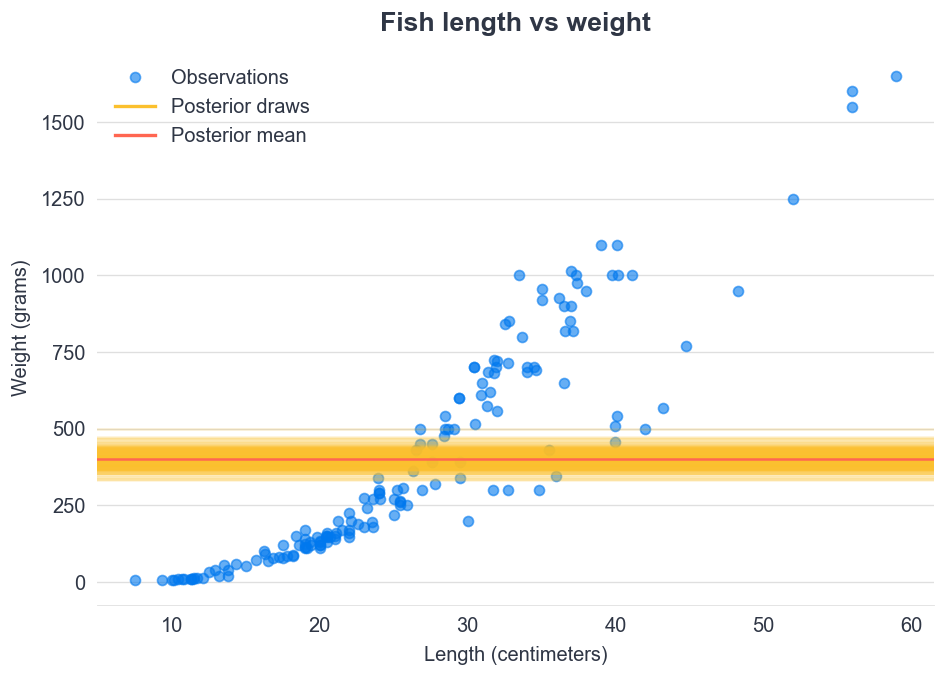

In [5]:
# Grab posterior draws for the intercept parameter
intercept_draws = idata.posterior["Intercept"].to_numpy()

# Create the visualization
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x=fish_data["Length1"], y=fish_data["Weight"], alpha=0.6)
ax.set(xlabel="Length (centimeters)", ylabel="Weight (grams)", title="Fish length vs weight")

for value in intercept_draws.flatten()[::10]:
    ax.axhline(value, color="C1", alpha=0.2)

ax.axhline(intercept_draws.mean(), color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left");

We just needed to change the name of the parameter from `"β0"` to `"Intercept"`. 

## Exercise 2: Deepen your `plot_cap()` knowledge

In this exercise you have to work with the fish data and the model we created in the "Transformations in Bambi" section. More concrete, you need to build the following model

```python
model = bmb.Model("log(Weight) ~ 1 + log(Length1)", data)
```
Notice you need to import the data to solve this exercise. Then create and fit the model mentioned above, and use `plot_cap()` with `Length1` as the variable for the horizontal axis.

```python
plot_cap(model, idata, "Length1")
```

Answer the following questions

* What do you see?
    * Is it a straight line?
    * Why?
* What is the scale of the variables in the horizontal and the vertical axis? Consider they're used with an inline transformation in the model.
    * Why?
* How can you put both variables in the transformed scale?
* And how you put everything on the untransformed scale?

### Solution

The first step is to create and fit the model.

In [6]:
model = bmb.Model("log(Weight) ~ 1 + log(Length1)", fish_data)
idata = model.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log(Length1), log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Now let's plot the fitted curve using `plot_cap()`. We use `use_hdi=False` because that option is producing noisy bands and we want our visualizations to look good! 

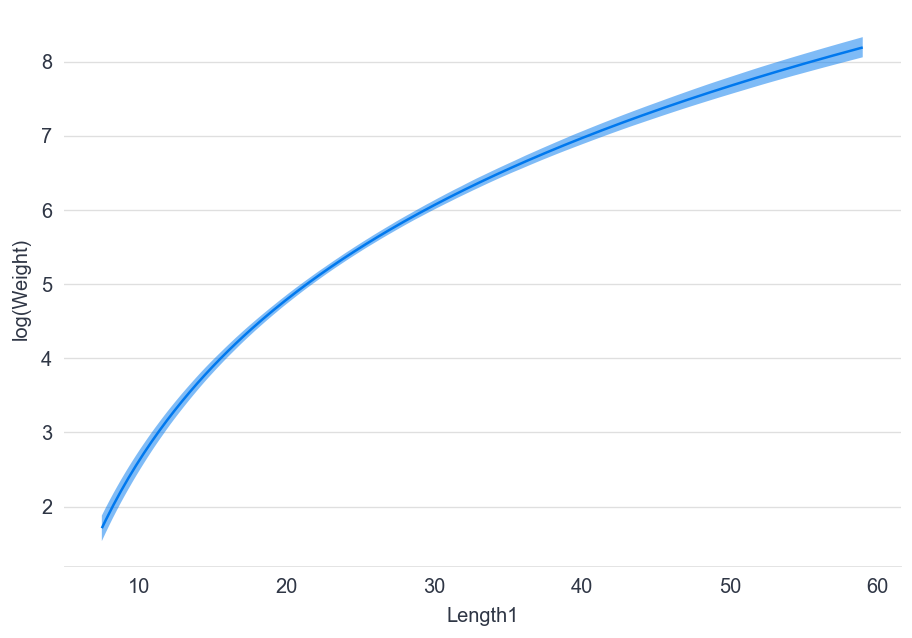

In [7]:
plot_cap(model, idata, "Length1", use_hdi=False, fig_kwargs={"figsize": (9, 6)});

**What do you see?**

The plot shows the fitted line for different values of the fish Length. It also contains a 94% credible interval around the mean. This interval is quite tight, denoting the high certainty the model has about the mean line. The line is not straight, because it shows `Length` vs `log(Weight)`, and the model is a straight line in the scale of `log(Length)` vs `log(Weight)`.

**What is the scale of the variables in the horizontal and the vertical axis?**

The visualization shows the horizontal variable in the original scale, while the vertical variable is in the transformed scale. We can notice it from scales of the variables, given by the tick values, and also from the labels.

**How can you put both variables in the transformed scale?**

We need to pass transformations to `plot_cap()`. Since the response is already transformed, we need to transform `Length1`.

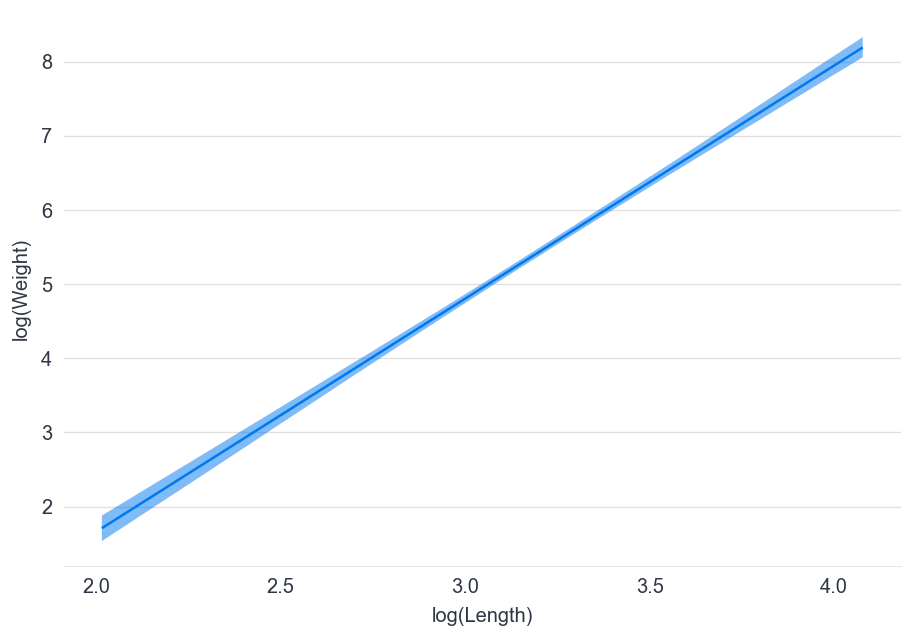

In [8]:
fig, axes = plot_cap(
    model, idata, "Length1", 
    use_hdi=False, transforms={"Length1": np.log}, fig_kwargs={"figsize": (9, 6)}
)
axes[0].set(xlabel="log(Length)");

**And how you put everything on the untransformed scale?**

Since `Length` is already in the original scale, we only need to tranform the response `log(Weight)` into the original scale using the exponential transform. We can also overlay the original data to make more informative and look better :)

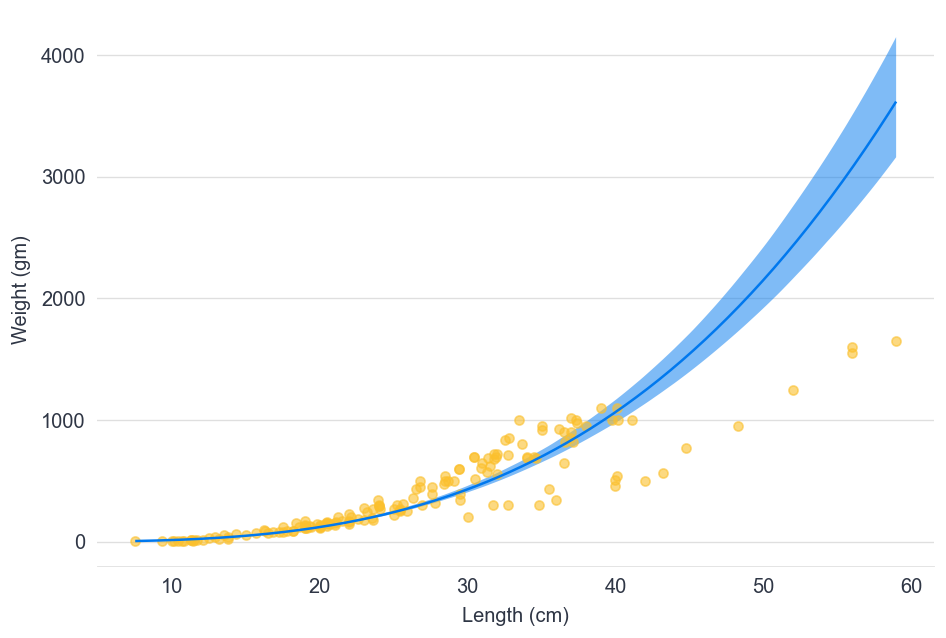

In [9]:
fig, axes = plot_cap(
    model, idata, "Length1", 
    use_hdi=False, transforms={"log(Weight)": np.exp}, fig_kwargs={"figsize": (9, 6)}
)
axes[0].scatter(fish_data["Length1"], fish_data["Weight"], alpha=0.6, s=30)
axes[0].set(xlabel="Length (cm)", ylabel="Weight (gm)");

## Exercise 3: Advanced operators

In the section "Transformations in Bambi" we showed that some custom operations needed to be written using a particular syntax. In this exercise you're going to experiment a little with with these operations to see how they work in practice. The goal here is not to arrive to a "correct" answer, but to see what are the different results when we try different formulas and trying to understand what's going on. Use the following simulated data:

In [10]:
rng = np.random.default_rng(1211)
size = 100
df = pd.DataFrame(
    {
        "response": rng.normal(loc=5, scale=0.5, size=size),
        "x": rng.normal(loc=10, scale=2, size=size),
        "y": rng.normal(size=size),
    }
)

Use the following formulas and explain what's happening

* `"response ~ x ** 100"`
* `"response ~ x / y"`
* `"response ~ (x + y) ** 2"`
* `"response ~ x / 100`"

It's fine if you can only describe what you see. At this point you're not expected to be an expert in formula notation. We'll cover more advanced stuff later in the course.

What is the difference between `"response ~ x + y"` and `"response ~ I(x + y)"`?

### Solution

In [12]:
bmb.Model("response ~ x / 100", df)

TypeError: Interaction with numbers does not make sense.

The error says `"TypeError: Interaction with numbers does not make sense."`. It looks like the `x / 100` is not being interpreted as a division, but rather as something that ends up adding an interaction... 🤔. 

In [13]:
bmb.Model("response ~ x ** 100", df)

Exponentiation on an individual variable returns the variable as it is.
Use {x**100} or I(x**100) to compute the math power.


Formula: response ~ x ** 100
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.904, sigma: 6.5255)
    x ~ Normal(mu: 0, sigma: 0.6402)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.5377)

In this case it works, but we get a message saying `"Exponentiation on an individual variable returns the variable as it is. Use {x**100} or I(x**100) to compute the math power."`. Basically, it's not computing the 100-th power of our predictor `x`. We notice that both from the message and the model information, which simply shows `x` in the priors section. It looks like doing `x ** 100` was the same as doing just `x` and the `**` operator has a different meaning in the formula mini-language.

In [14]:
bmb.Model("response ~ x / y", df)

Formula: response ~ x / y
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.904, sigma: 6.5259)
    x ~ Normal(mu: 0, sigma: 0.6402)
    x:y ~ Normal(mu: 0, sigma: 0.131)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.5377)

Again it worked! And this time without any messages, that's cool! Let's explore the terms it added to the model.

We see we have the main effect of `x` the interaction between `x` and `y`, `x:y`. Bingo! That's why the first formula said we were trying to compute an interaction between a variable and a number! 

Turns out `x / y` is a shortcut for `x + x:y`. And when we did `x / 100` it was trying to do `x + x:100` which involves an interaction between a variable and a constant and doesn't make sense.

In [15]:
bmb.Model("response ~ (x + y) ** 2", df)

Formula: response ~ (x + y) ** 2
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.904, sigma: 6.5266)
    x ~ Normal(mu: 0, sigma: 0.6402)
    y ~ Normal(mu: 0, sigma: 1.3379)
    x:y ~ Normal(mu: 0, sigma: 0.131)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.5377)

Yay! Again this worked! But, what happened?

Looks like `(x + y) ** 2` was mapped to `x + y + x:y`. So it seems that `**` does have a meaning in the formula language, but it's a special one. 

In fact, the power operator allows us to write interactions between many variables in a short manner. The value of the power is the order of the interaction, and it computes all the interactions between the terms up to the $n$ interaction. For instance

`(x + y + z) ** 3` would be mapped to `x + y + z + x:y + x:z + y:z + x:y:z`.

**What is the difference between `"response ~ x + y"` and `"response ~ I(x + y)"`?**

Let's find out!

In [16]:
bmb.Model("response ~ x + y", df)

Formula: response ~ x + y
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.904, sigma: 6.5262)
    x ~ Normal(mu: 0, sigma: 0.6402)
    y ~ Normal(mu: 0, sigma: 1.3379)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.5377)

In [17]:
bmb.Model("response ~ I(x + y)", df)

Formula: response ~ I(x + y)
Family name: Gaussian
Link: identity
Observations: 100
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.904, sigma: 5.7614)
    I(x + y) ~ Normal(mu: 0, sigma: 0.5658)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.5377)

As we already know, `"response ~ x + y"` results in a model with two predictors, `x` and `y`. But if we use the `I()` function within the formula, it means something different. As result, we have a single predictor which is equal to the sum of both `x` and `y`. This is different than having two separated predictors because there's a single slope for this new variable "x + y" and not one for each separately.

Long story short, if we pass something within `I()`, it's evaluated as regular Python.

## Exercise 4: Experiment!

In the "Parameter identifiability" section we simulated some data to grasp what non-identifiability means using a controlled scenario. The code we used is the following:

In [18]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=50)
noise = rng.normal(scale=0.5, size=50)
y = b0 + b1 * x + noise

And then we created the following PyMC model

In [19]:
with pm.Model() as weird_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    b2 = pm.Normal("b2")
    mu = b0 + b1 * x + b2 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

The goal of this exercise is to have you run several experiments to understand how parameter non-identifiablity affects sampling times and the quality of the draws obtained. You are asked to

* Repeat this experiment with different sample sizes.
    * Use $n=500$ 
    * Use $n=2000$
* Explore the posterior of the slopes
* Do you get any warnings?
* Explore the correlation between $b_1$ and $b_2$. 
    * Does it improve with more data?

Now, use the correct model, with a single slope

```python
with pm.Model() as good_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    mu = b0 + b1 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
```

* Fit it using $n=500$ and $n=2000$, as done previously
* Compare the sampling speed with the previous model
    * What can you conclude about the effects of parameter correlations in sampling speed?
* Can you recover the true slope?
* Do you get any warnings?

Finally, you're asked to reproduce the flawed model in Bambi. To do so, you need to use the formula `"y ~ x + x"`. 

* What happens?
* Why do you think it works that way?

### Solution

Use the given snippet to simulate data with $n=500$

In [20]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=500)
noise = rng.normal(scale=0.5, size=500)
y = b0 + b1 * x + noise

Now fit the model

In [21]:
with pm.Model() as weird_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    b2 = pm.Normal("b2")
    mu = b0 + b1 * x + b2 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    idata_1 = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b0, b1, b2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.


Same thing, for $n=2000$

In [22]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=2000)
noise = rng.normal(scale=0.5, size=2000)
y = b0 + b1 * x + noise

with pm.Model() as weird_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    b2 = pm.Normal("b2")
    mu = b0 + b1 * x + b2 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    idata_2 = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b0, b1, b2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.


**Explore the posterior of the slopes**

In [23]:
az.summary(idata_1, var_names=["b1", "b2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,1.304,0.713,0.056,2.669,0.028,0.02,652.0,772.0,1.0
b2,1.195,0.714,-0.141,2.468,0.028,0.02,656.0,741.0,1.0


In [24]:
az.summary(idata_2, var_names=["b1", "b2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,1.257,0.707,-0.022,2.612,0.021,0.015,1185.0,965.0,1.0
b2,1.222,0.707,-0.153,2.488,0.021,0.015,1185.0,966.0,1.0


**Do you get any warnings?**

Nope. It looks like the sampler does not have any trouble exploring the complicated posterior that can arise with this model.

**Explore the correlation between $b_1$ and $b_2$**

As we did in the lesson, we can compute hte correlation and visualize with a pairplot.

-0.9992922257830209


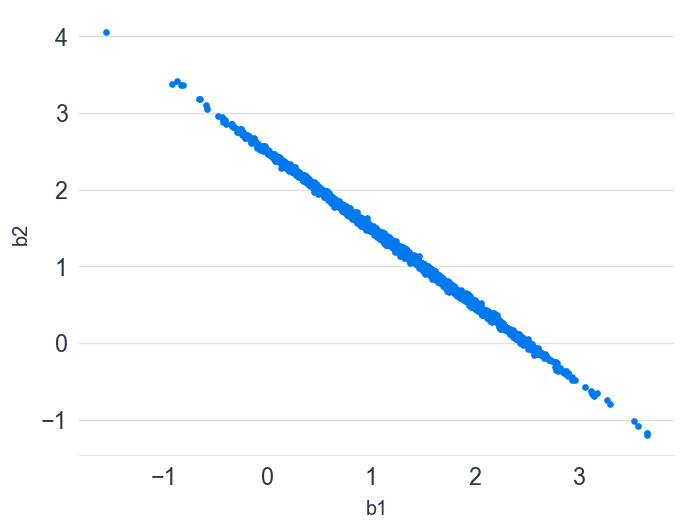

In [25]:
print(xr.corr(idata_1.posterior["b1"], idata_1.posterior["b2"]).item())
az.plot_pair(idata_1.posterior, var_names=["b1", "b2"]);

-0.9998426634024593


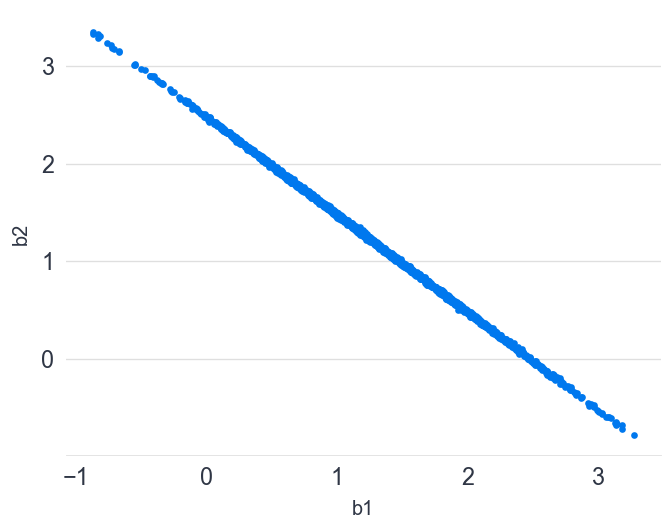

In [26]:
print(xr.corr(idata_2.posterior["b1"], idata_2.posterior["b2"]).item())
az.plot_pair(idata_2.posterior, var_names=["b1", "b2"]);

Correlations are incredibly high in both cases. What's more, it does not improve with more data. All the opposite, it gets even worse. In the lesson we used $n=50$ and the correlation was -0.991. Here we used $n=500$ and $n=2000$ and we got -0.9993 and -0.9998 respectively, which are virtually -1, indicating a perfect correlation.

Now, let's use the well identified model

In [27]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=500)
noise = rng.normal(scale=0.5, size=500)
y = b0 + b1 * x + noise

with pm.Model() as good_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    mu = b0 + b1 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    idata_3 = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b0, b1, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [28]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=2000)
noise = rng.normal(scale=0.5, size=2000)
y = b0 + b1 * x + noise

with pm.Model() as good_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    mu = b0 + b1 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    idata_4 = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b0, b1, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


**Compare the sampling speed with the previous model**

In both cases, the models fitted blazingly fast. Even though the sample size increased 4x, the sampling speed was almost the same. This contrasts with the results from the non-identified model, where it took ~50 and ~120 seconds to fit the models respectively. We can conclude highly correlated posteriors affect negatively the sampling speed. This is a made-up case where the correlation is extremely high, and thus we see enormous differences. However, it's important to keep an eye on the identifiability of our model parameters and the correlation between parameters in general.

**Can you recover the true slope?**

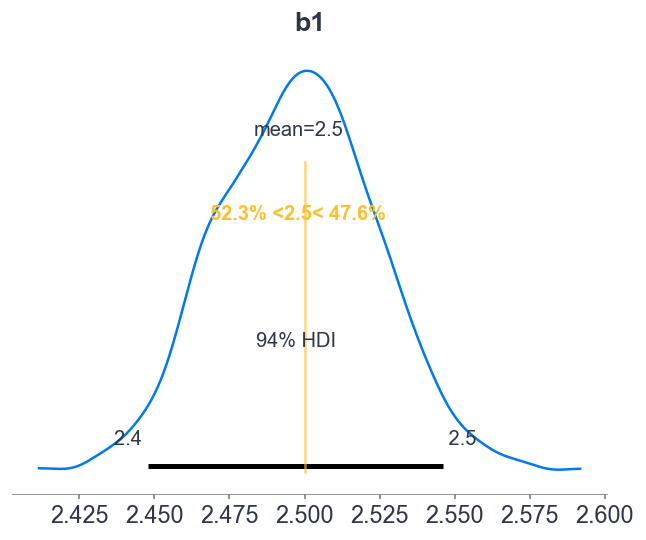

In [29]:
az.plot_posterior(idata_3, var_names="b1", ref_val=2.5);

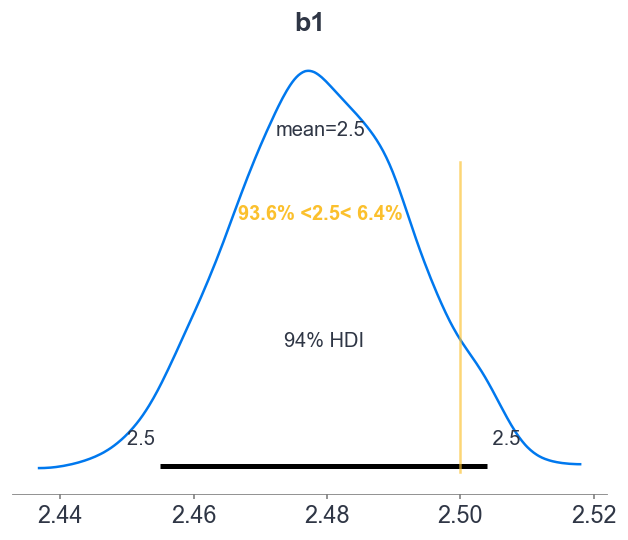

In [30]:
az.plot_posterior(idata_4, var_names="b1", ref_val=2.5);

In both cases we can recover the true slope. Naturally, when there's more data available, the uncertainty around the estimation is smaller.

**Do you get any warnings?**

Nope. The sampler does not have any trouble exploring the posterior as we can expect from this simple model.

Now, time to reproduce the flawed model in Bambi

In [31]:
df = pd.DataFrame({"y": y, "x": x})
model = bmb.Model("y ~ x + x", df)
model

Formula: y ~ x + x
Family name: Gaussian
Link: identity
Observations: 2000
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 4.256, sigma: 11.0262)
    x ~ Normal(mu: 0, sigma: 6.3652)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 2.2061)

What happens? Well, we used `x` twice in the model formula, but it appears only once in the model summary. This is because Bambi automatically solves non-identifiability issues, and it prevents `x` from appearing twice, creating an identifiability problem. This is similar to what happened in the section "Modeling categories" where Bambi automatically dropped a species for the same reason.

In a summary, Bambi always gets you covered when it comes to avoiding identifiability issues.

## Exercise 5: Try different numerical predictors

In the section "An end to end trip with Bambi" we computed the $R^2$ coefficient of the following model

```python
model = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", data)
```

We got an $R^2$ equal to 0.984, which is very high. 

In this exercise you're asked to use the other numerical predictors in the dataset in place of `Length1`, compute the $R^2$ of those models, and compare to what we got with `Length1`.

**Notes**

You have to create two extra models. One using `Height` and other using `Width` as predictors. You can keep the same strcuture of varying intercepts and varying slopes. 

**Optional**

Combine two or more of the numerical predictors, compute the $R^2$ coefficient, and compare with the previous models. Does adding more numerical predictors improve $R^2$?

### Solution

In [32]:
model_height = bmb.Model("log(Weight) ~ 0 + Species + log(Height):Species", fish_data)
idata_height = model_height.fit(random_seed=1211) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Height):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


In [33]:
model_width = bmb.Model("log(Weight) ~ 0 + Species + log(Width):Species", fish_data)
idata_width = model_width.fit(random_seed=1211) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Width):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


Remember we need draws from the posterior predictive distribution to compute $R^2$. That's why we use `.predict()` with `kind="pps"` below.

Let's get $R^2$ using the model based on `Height`

In [34]:
model_height.predict(idata_height, kind="pps")
y_true = idata_height.observed_data["log(Weight)"].to_numpy()
y_pred = idata_height.posterior_predictive["log(Weight)"].stack(sample=("chain", "draw")).T.to_numpy()
az.r2_score(y_true, y_pred)

r2        0.980197
r2_std    0.002398
dtype: float64

And now the  $R^2$ using the model based on `Width`

In [35]:
model_width.predict(idata_width, kind="pps")
y_true = idata_width.observed_data["log(Weight)"].to_numpy()
y_pred = idata_width.posterior_predictive["log(Weight)"].stack(sample=("chain", "draw")).T.to_numpy()
az.r2_score(y_true, y_pred)

r2        0.971526
r2_std    0.003343
dtype: float64

In both cases, the $R^2$ values are very high (0.98 and 0.97, respectively). None of them is larger than the one we got using `Length1` as predictor, but they're so close that practically speaking they're the same. In othe words, using any of `Length1`, `Height` or `Width` would give a similar predictive capacity in terms of the coefficient of determination $R^2$.

## Exercise 6: Interaction effects

In this exercise we're going to learn more about interaction effects. In the section "The full model" we covered that the different `log(Length)` slopes per `Species` is an interaction between `log(Length)` and `Species`. More generally, this is an interaction between a numeric and a categorical variable. The result was as many slopes as species in our dataset.

Now we're going to exercise another type of interaction, between two numerics, which is the first case in the following diagram.

<center>
  <img src="imgs/interaction_symbol.png" style="width:950px"; />
</center>

We expect this to give us a single new slope, which is multiplied by the product of the two numerical covariates.

### The data

In [36]:
mtcars_data = pd.read_csv("data/mtcars.csv")
mtcars_data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973--74 models). The following is a description of the variables:

* `mpg`: Miles/(US) gallon
* `cyl`: Number of cylinders
* `disp`: Displacement (cu.in.)
* `hp`: Gross horsepower
* `drat`: Rear axle ratio
* `wt`: Weight (1000 lbs)
* `qsec`: 1/4 mile time
* `vs`: Engine (0 = V-shaped, 1 = straight)
* `am`: Transmission (0 = automatic, 1 = manual)
* `gear`: Number of forward gears

## The models

We're going to us the Gross horsepower (`hp`) and the Weight (`wt`) to predict the fuel consumption in Miles per US gallon (`mpg`).

**Main effects model**

$$
\text{mpg} = \beta_0 + \beta_1 \text{hp} + \beta_2 \text{wt} + \varepsilon
$$

**Interaction effects model**

$$
\text{mpg} = \beta_0 + \beta_1 \text{hp} + \beta_2 \text{wt} + \beta_3 \text{hp} \cdot \text{wt}  + \varepsilon
$$

* Build and fit the main effects model
* Build and fit the model with the interaction effects
* Explore the posterior of both models
    * What can you conclude about the coefficient of the interaction effect?
* Use `plot_cap()` to compare the fitted curves
    * Map `hp` to the horizontal axis and `wt` to the color or the panel.
    * Can you describe how the interaction affects the fitted curves?

### Solution

Let's create the model with the main effects only. The formula for this model is `"mpg ~ 1 + hp + wt"`.

In [37]:
model_main = bmb.Model("mpg ~ 1 + hp + wt", mtcars_data)
idata_main = model_main.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, hp, wt, mpg_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


Now, let's continue with the model that incorporates the interaction effect. The formula for this model is `"mpg ~ 1 + hp + wt + hp:wt"`.

In [38]:
model_interaction = bmb.Model("mpg ~ 1 + hp + wt + hp:wt", mtcars_data)
idata_interaction = model_interaction.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, hp, wt, hp:wt, mpg_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


It's time to explore the posteriors. We're going to use forestplots arranged in a figure with multiple panels. The goal is to be able to compare the posterior of every parameter under both models, making it easier to detect differences.

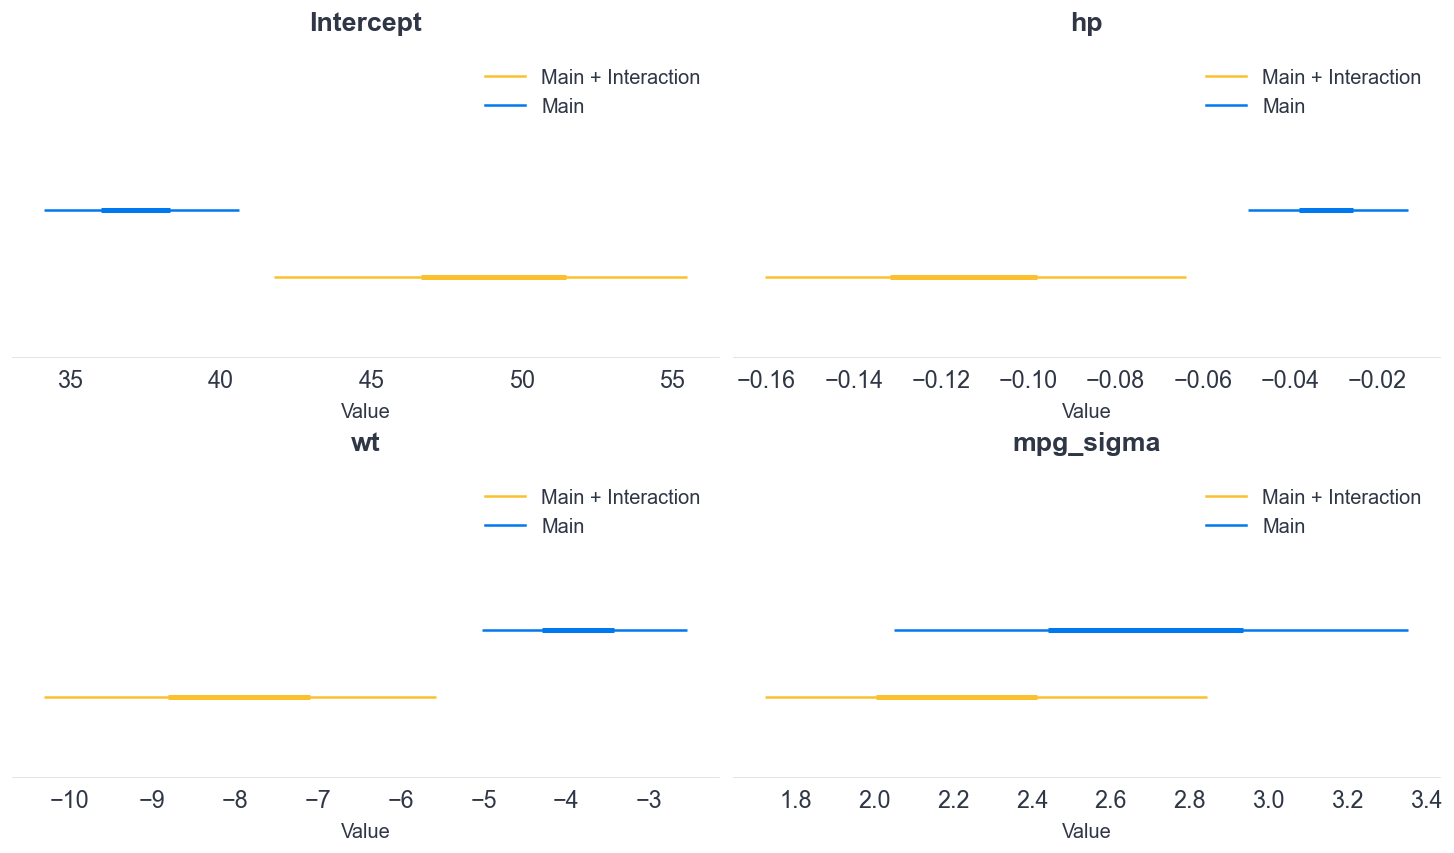

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7), layout="constrained")
for ax, var_name in zip(axes.ravel(), ["Intercept", "hp", "wt", "mpg_sigma"]):
    az.plot_forest(
        [idata_main, idata_interaction],
        model_names=["Main", "Main + Interaction"],
        combined=True,
        var_names=var_name,
        ax=ax
    );
    ax.set(title=var_name, xlabel="Value", yticks=[])

There's definitely a change in the posterior of the paramaters that are common to both models when we consider an interaction. In all cases, except for `mpg_sigma`, these posteriors don't even overlap. Also, in all cases except for `mpg_sigma`, all the posteriors under the main effects model are more certain. 

Curiously, the posterior for `mpg_sigma` is smaller when we include the interaction effect. This does make sense because we have more parameters to explain the variability in the response. While there's some overlap between these posteriors, the bulk of the posteriors under both models given by the thicker line don't overlap. 

Let's visualize the posterior for the interaction effect parameter.

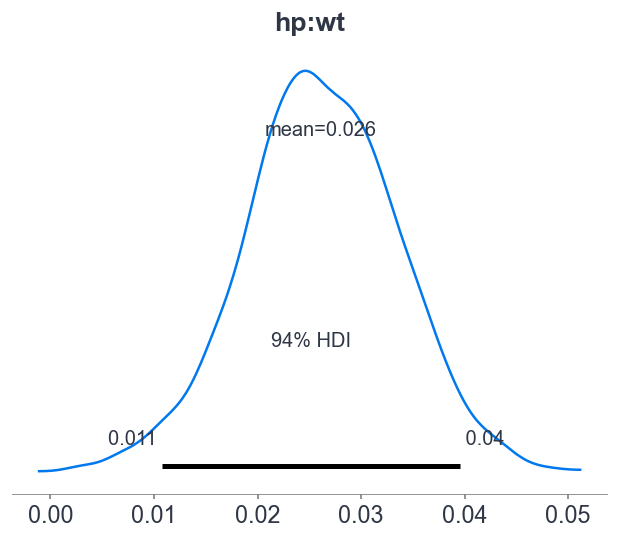

In [40]:
az.plot_posterior(idata_interaction, "hp:wt");

In [41]:
(idata_interaction.posterior["hp:wt"] > 0).mean().item()

0.9995

In principle it may seem the posterior assings most of the probability to values very close to 0. And in part, that's true. However, notice there probability the interaction effect parameter being greater than 0 is almost equal to 1, meaning it makes sense to keep an interaction effect in the model. 

We can visualize the fitted curves using `plot_cap()`. We map `hp` to the horizontal axis and `wt` to the color. Since `wt` is a numeric variable, the function is going to take 5 equally spaced quantiles going from 0% to 100%.

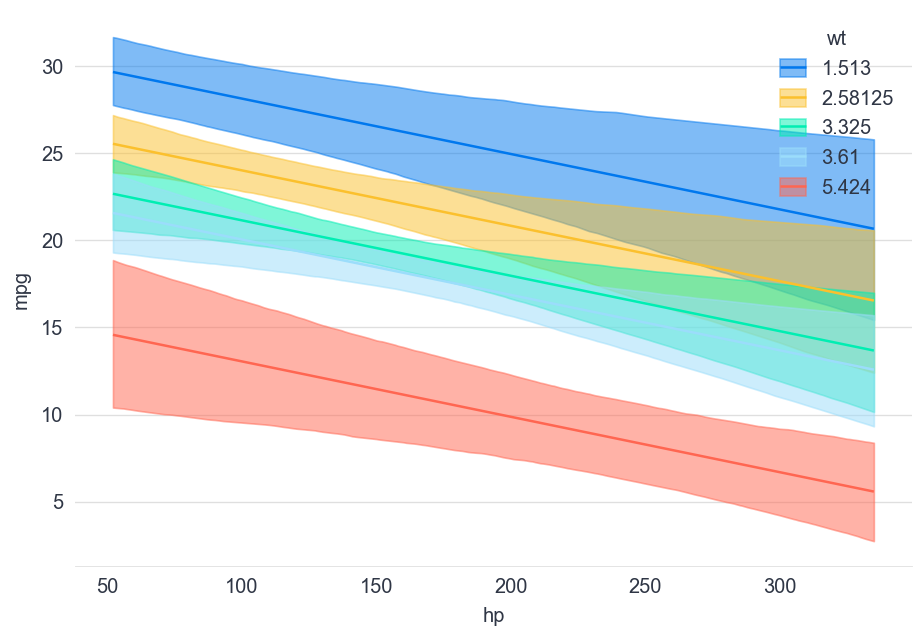

In [42]:
plot_cap(model_main, idata_main, ["hp", "wt"], use_hdi=False, fig_kwargs={"figsize": (9, 6)});

We can read the visualization as follows:

* The relation between horse power (`hp`) and miles per gallon (`mpg`) is negative. The larger the horse power, the smaller the number of miles per hour.
* Also the relation between weight (`wt`) and miles per gallon (`mpg`) is negative. The heavier the car, the less efficient the car in terms of the number of miles per hour. We can see this since curves corresponding to larger `wt` are below curves with lower `wt`.

What does the model with the interaction have for us?

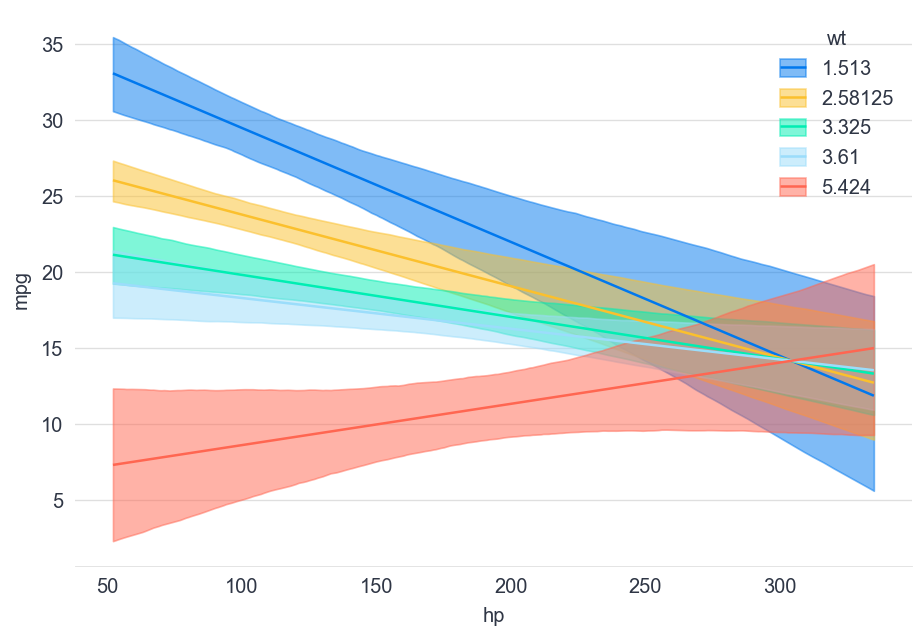

In [43]:
plot_cap(model_interaction, idata_interaction, ["hp", "wt"], use_hdi=False, fig_kwargs={"figsize": (9, 6)});

We see something different now. The `hp` slope **is not the same** for all the values of `wt`. And this is exactly the meaning of an interaction! 

As the value of `wt` gets bigger, the slope goes from negative, to close to zero, to finally be slightly positive. So it looks like the negative association between `hp` and `mpg` is milder for heavier cars. Like heavier cars increase `hp` more efficiently than lighter ones.

We could conclude the exercise now, or push it a little further to really understand why the interaction is working this way. We're going to split the lines above into multiple panels so we can overlay the observations and see whether the line is actually a good fit or not.

Since `plot_cap()` is using quantiles to select several values of `wt`, we do the same so we can filter the data.

In [44]:
mtcars_data["wt_qt"] = pd.qcut(mtcars_data["wt"], 5)

And then we just create the plot. See we map `wt` both to the color and the panel. Why? It looks fancy!

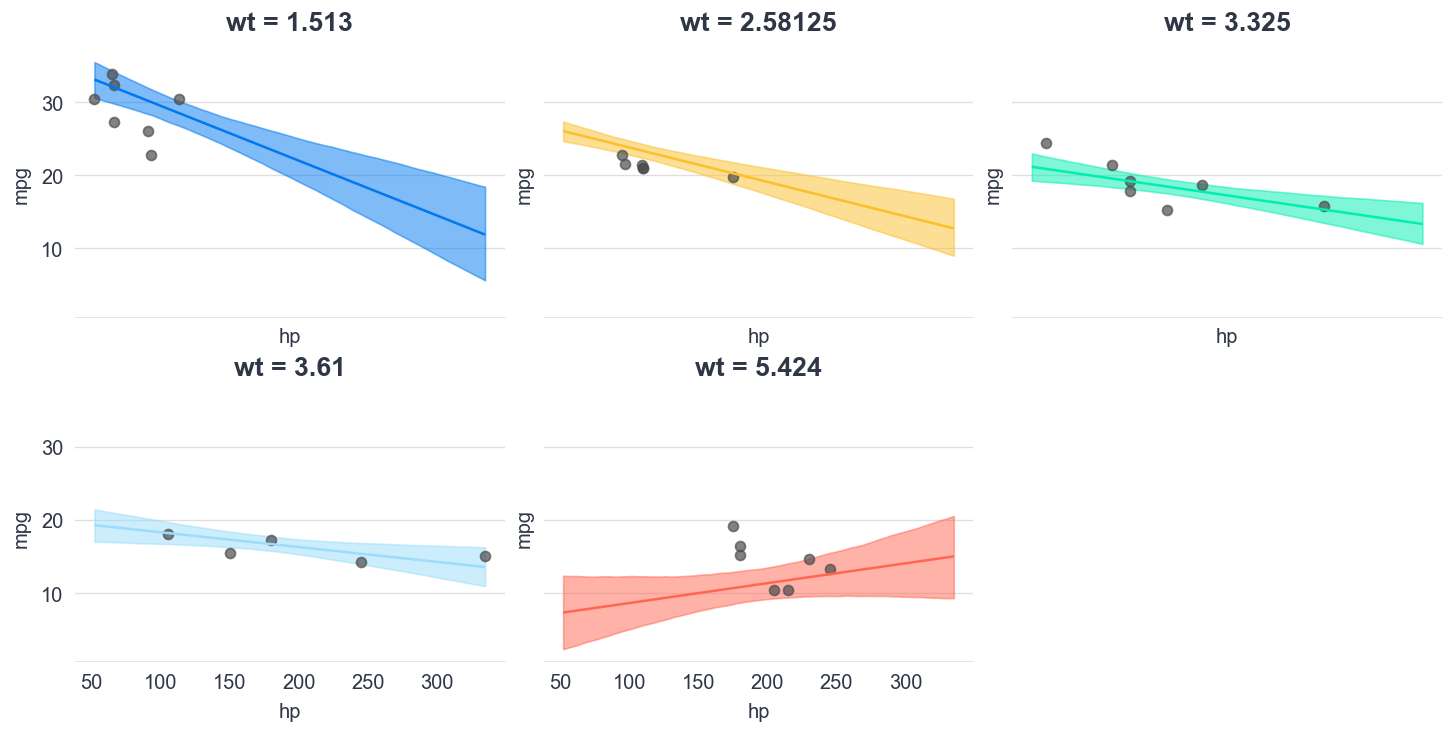

In [45]:
fig, axes = plot_cap(
    model_interaction, 
    idata_interaction, 
    ["hp", "wt", "wt"], 
    use_hdi=False, 
    legend=False,
    fig_kwargs={"figsize": (12, 6), "sharey": True, "sharex": True, "layout": "constrained"}
);

for ax, (qt, df) in zip(axes.ravel(), mtcars_data.groupby("wt_qt")):
    ax.scatter(df["hp"], df["mpg"], alpha=0.7, color="0.3")  

This impressive visualization shows a reasonable fit in all cases. Perhaps, the fit is not that good in the last panel. Why is this happening? The reason is the red curve is fitted using a `wt` value of `5.424`, the maximum observed value. But the dots there correspond to `wt` values between 3.77 and 5.424, and so the slope does not represent all the dots equally well, since all of them but one correspond to a smaller `wt` value.

In [46]:
mtcars_data["wt_qt"].cat.categories

IntervalIndex([(1.512, 2.349], (2.349, 3.158], (3.158, 3.44], (3.44, 3.77], (3.77, 5.424]], dtype='interval[float64, right]')

To conclude, we can say the model that incorporates an interatction effect makes more sense than a main effects only model. It allows to reflect better all the information in the data. 

This exercise was a great opportunity to learn more about interaction effects, how to use them with Bambi, and keep upgrading our data science skills.

**A note for the nerd** 

If you still want to keep learning more, you could compute the $R^2$ coefficient to compare both models. Also, if you've ever done model comparison using ArviZ, this is a good opportunity to do so.

## Exercise 7: A model with many predictors 

This is the continuation of Exercise 4 from the previous lesson, where we worked with the construction problem. Now we're going to use all the predictors, not just cement and water, to predict the concrete strength. 

The goal of this exercise is to learn how scaling of the predictors may help our sampler to work faster. Also, it challenges you to come up with an alternative that will prevent our model from giving negative predictions, a problem we already detected in Exercise 4 from the previous lesson.

If you want to refresh your knowledge about the `scale()` transform, revisit the section "Transformations in Bambi".

### The data

The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)) and the following variables were measured and recorded

* **cement** - Portland cement in kg/m3
* **slag** - Blast furnace slag in kg/m3
* **fly_ash** - Fly ash in kg/m3
* **water** - Water in liters/m3
* **superplasticizer** - Superplasticizer additive in kg/m3
* **coarse_aggregate** - Coarse aggregate (gravel) in kg/m3
* **fine_aggregate** - Fine aggregate (sand) in kg/m3
* **age** - Age of the sample in days
* **strength** - Concrete compressive strength in megapascals (MPa)

In [47]:
concrete_data = pd.read_csv("data/concrete.csv")
concrete_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [48]:
concrete_data_new = pd.DataFrame(
    {
        "cement": [520, 300, 400],
        "slag": [100, 50, 70],
        "fly_ash": [120, 40, 90],
        "water": [228, 160, 200],
        "superplasticizer": [22, 16, 20],
        "coarse_aggregate": [1000, 800, 900],
        "fine_aggregate": [825, 650, 775],
        "age": [48, 128, 80],
    }
)

### The models

Since we're using all the predictors, the formulas are quite big. We could build them using Python, but for the sake of clarity we prefer to just write them down.

**Unscaled model**

```python
formula = "strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age"
```

**Scaled model**

```python
formula = "strength ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
```

### The questions

* Build and fit the unscaled model
* Build and fit the scaled model
* Compare sampling times
* Predict the weight of the three samples in the data frame `concrete_data_new` using both models
    * Do predictions differ between models?
    * Why?
* Plot the posterior predictive distribution
    * If the model predicts negative strenghts, propose a model that fixes this problem.
    * Fit the new model and explore the posterior predictive distribution again.
    * What can you conclude?

### Solution

**Build and fit the unscaled model**

In [49]:
formula = "strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age"
model_unscaled = bmb.Model(formula, concrete_data)
idata_unscaled = model_unscaled.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cement, slag, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age, strength_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


**Build and fit the scaled model**

In [50]:
formula = "strength ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
model_scaled = bmb.Model(formula, concrete_data)
idata_scaled = model_scaled.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), strength_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


**Compare sampling times**

In this opportuniy sampling times are almost the same. However, it's nice to know in many cases one can expect better sampling times when using standardized scales since one makes things more tractable for the sampler.

**Predict the weight of the three samples in the data frame `concrete_data_new` using both models**

We can use the `.predict()` method making sure we correctly align the model and the `InferenceData` object. This is an out-of-sample prediction, because we're using samples that were not part of the training set, so we pass it into the `data` argument.

In [51]:
model_unscaled.predict(idata_unscaled, data=concrete_data_new, kind="pps")
model_scaled.predict(idata_scaled, data=concrete_data_new, kind="pps")

Once we have predictions, we can use `az.plot_posterior()` to get predictions from both models in the same figure.

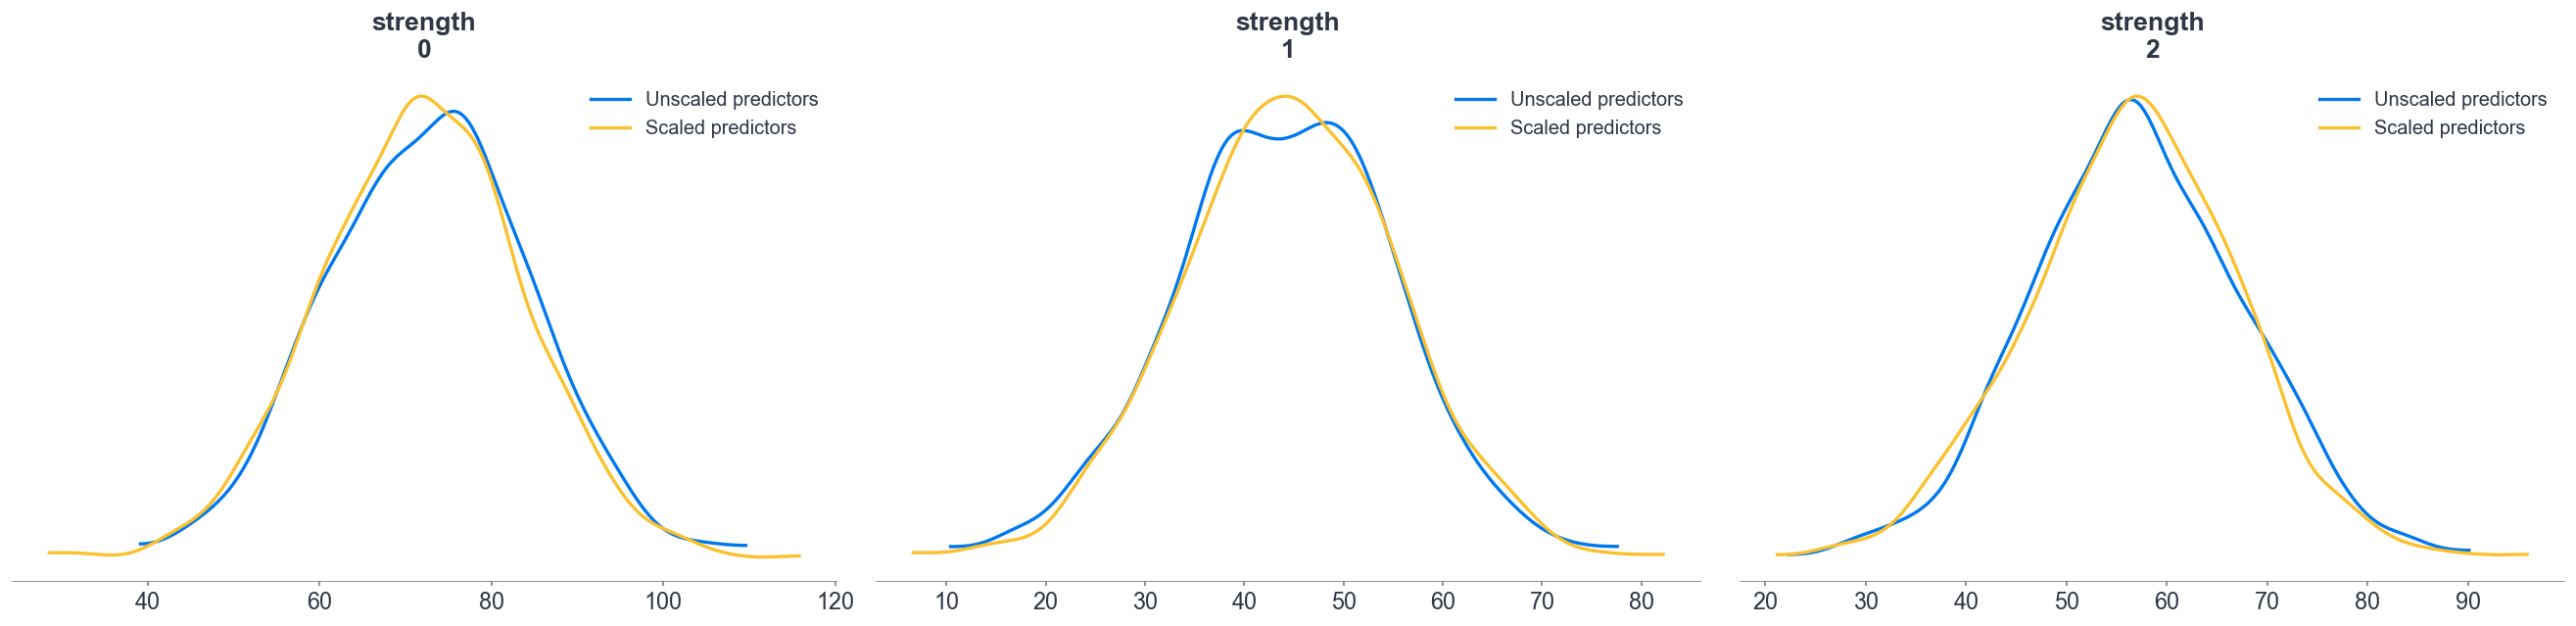

In [52]:
axes = az.plot_posterior(
    idata_unscaled.posterior_predictive["strength"],
    hdi_prob="hide",
    point_estimate=None,
    lw=2,
    label="Unscaled predictors"
)
az.plot_posterior(
    idata_scaled.posterior_predictive["strength"],
    hdi_prob="hide", 
    point_estimate=None,
    ax=axes, 
    color="C1",
    lw=2,
    label="Scaled predictors"
)
plt.tight_layout()

**Do predictions differ between models?**

Ta da!! No matter one model used the original predictors and the other used the scaled predictors, both models show the same predictions when we pass in new data. The reason is both models are using exactly the same information in equivalent ways. Changing the scale of the predictor, or centering it, does not change the information it gives to the model.

**Plot the posterior predictive distribution**

We're going to get the draws from the posterior predictive distribution. But this time we won't pass any data frame, meaning it's going to use the observed data that was used to fit the model. We use the scaled model, but it would be the same to use the unscaled one.

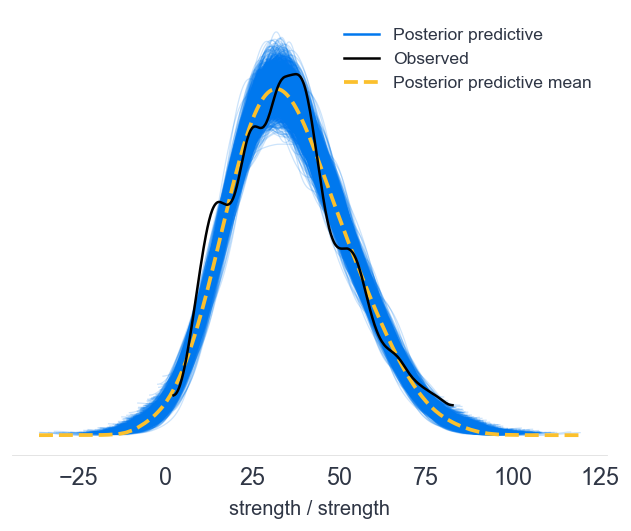

In [53]:
model_scaled.predict(idata_scaled, kind="pps")
az.plot_ppc(idata_scaled);

The good news is the posterior predictive distribution seems to match the observed distribution very well. That's a great point! However, the model predicts negative strengths, and that's not very nice. The reason is because we're using an unbounded distribution for the likelihood (Gaussian) and the response is bounded at zero.

**Propose a model that fixes this problem**

One alternative one can quickly try is to use a logarithm transform for the response. We just need to wrap `strength` with `log()` in the model formula.

In [54]:
formula = "log(strength) ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
model_alternative = bmb.Model(formula, concrete_data)
idata_alternative = model_alternative.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), log(strength)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


**Explore the posterior predictive distribution again**

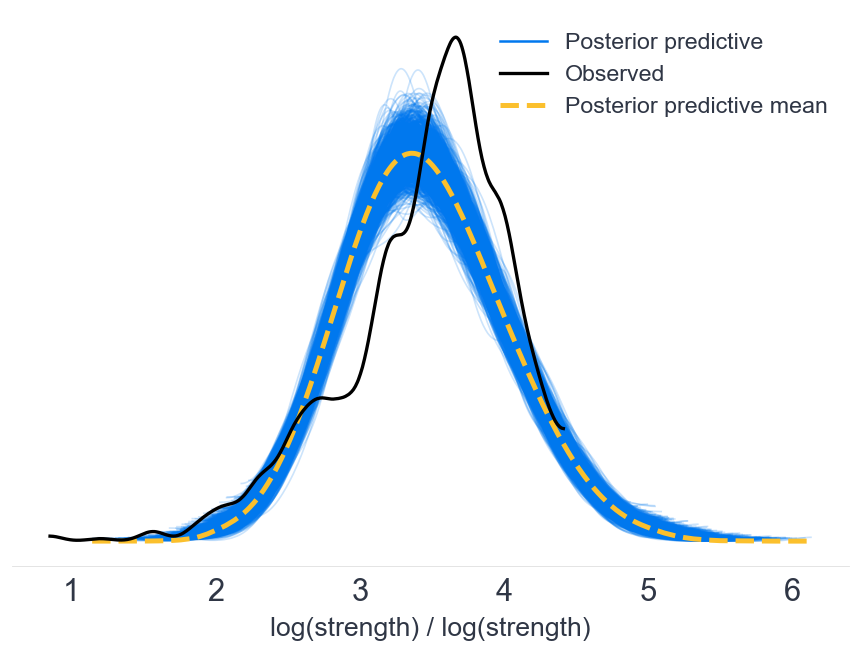

In [55]:
model_alternative.predict(idata_alternative, kind="pps")
az.plot_ppc(idata_alternative, figsize=(9, 6));

Let's also get the posterior predictive checks in the original scale. 

In [56]:
idata_alternative.posterior_predictive["strength"] = np.exp(idata_alternative.posterior_predictive["log(strength)"])
idata_alternative.observed_data["strength"] = np.exp(idata_alternative.observed_data["log(strength)"])

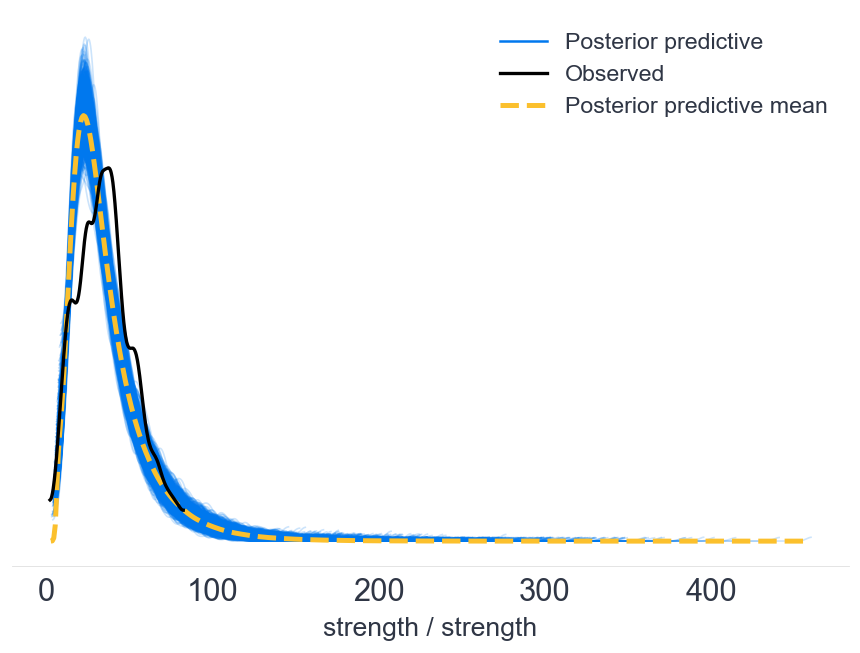

In [57]:
az.plot_ppc(idata_alternative, var_names="strength", figsize=(9, 6));

**What can you conclude?**

Modeling the logarithm of the response solves the problem of having to deal with negative predictions, but the posterior predictive distribution has a right tail that is longer than what we would like. Also, there's seem to be a shift between the mode (and bulk) of the posterior predictive distribution and the observed distribution.

### Citations

The data for this exercise originally comes from

* I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).